In [1]:
import os
import numpy as np
import pylab as plt
%matplotlib inline

import cv2

import csgan as cs

def canny(d_in,R,meth,edd):
    d = d_in
    if (R!=0):
        dt = np.fft.fft2(d)
        if meth=='g':
            for i in range(sz):
                for j in range(sz):
                    k2 = 1.*(i*i+j*j)/d.shape[0]
                    dt[i,j]=dt[i,j]*np.exp(-k2*R*R/2)

        if meth=='tp':
            for i in range(sz):
                for j in range(sz):
                    k = np.sqrt(0.001+i*i+j*j)/sz
                    dt[i,j]=dt[i,j]* 3*(np.sin(k*R)-k*R*np.cos(k*R))/(k*R)**3

        d = np.fft.ifft2(dt)
        d = abs(d)

    if edd=='lap':
        d = cv2.Laplacian(d,cv2.CV_64F)

    if edd=='sob':
        sobelx = cv2.Sobel(d,cv2.CV_64F,1,0,ksize=3)
        sobely = cv2.Sobel(d,cv2.CV_64F,0,1,ksize=3)
        d =np.sqrt(sobelx**2+sobely**2)

    if edd=='sch':
        scharrx = cv2.Scharr(d,cv2.CV_64F,1,0)
        scharry = cv2.Scharr(d,cv2.CV_64F,0,1)
        d =np.sqrt(scharrx**2+scharry**2)
        
    return d

def filt_all(maps,func):
    out1 = []
    for m in maps:
        out1.append(func(m))
        
    return np.stack([maps,np.array(out1)],axis=3)

def func(dt):
    return canny(dt,0,'none','sch')

In [2]:
dp = cs.Data_Provider('../../dataset/map1n_allz_rtaapixlw_2048_3.fits')

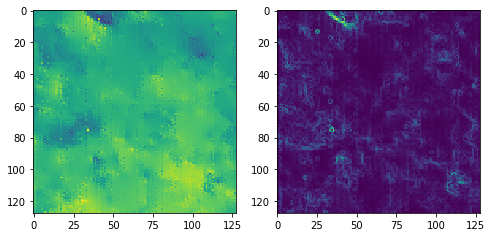

In [3]:
dt = filt_all(dp(10,128),func)
dt.shape
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,18))
ax1.imshow(dt[0,:,:,0])
ax2.imshow(dt[0,:,:,1])

In [4]:
image_size = 64

def dpp(n):
    return dp(n,image_size).reshape(n,image_size,image_size,1)

# run_config.gpu_options.allow_growth = True

dcgan = cs.DCGAN(
    data_provider = dpp,
    batch_size=17,
    gf_dim=16, df_dim=64,
    gfc_dim=1024, dfc_dim=1024,
    z_dim=2048,
    checkpoint_dir='checkpoint')

dcgan.train(num_epoch=1,batch_per_epoch = 2)

Output size is same as input's!
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/64_64/DCGAN.model-2
 [*] Success to read DCGAN.model-2
 [*] Load SUCCESS
Epoch: [ 0] [   0/   2] time: 3.6738, d_loss: 7.94279432, g_loss: 0.73807192
./samples/train_00_0000.png
Epoch: [ 0] [   1/   2] time: 7.2340, d_loss: 4.78302383, g_loss: 0.47372016


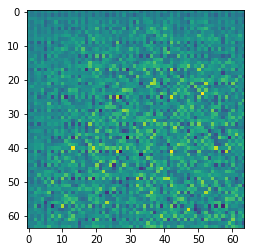

In [5]:
sample_z = np.random.normal(size=(5, dcgan.z_dim))
plt.imshow(dcgan.generate(sample_z)[0,:,:,0])